In [ ]:
import matplotlib as m
import matplotlib.pyplot as plt
from operator import itemgetter
import pandas as pd
import geopandas as gpd
import numpy as np
import copy
from scipy import stats
import json
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.colorbar import ColorbarBase
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy
import string
mpl.rcParams['figure.figsize']=(20,9)
mpl.style.use('ggplot')

In [ ]:
# Summation of the value insde a dictionary
def dictsum(myDict):
    sum = 0
    for i in myDict:
        sum = sum + myDict[i]
    return sum

# 1. EORA

In [ ]:
# @title Read files
# VSL
file = open("Data/VSL_dict_eora.json", "r")
VSL_eora = file.read()
VSL_eora = json.loads(VSL_eora)

for country in VSL_eora:
  VSL_eora[country] = VSL_eora[country] * 1.04 * 1000000 # unit:usd

# We only care about the country sequence
file = open("Data/Total_pop.json", "r")
population2 = file.read()
population2 = json.loads(population2)
Countries = list(population2.keys())

file = open("First_review_data/Total_pop_eora.json", "r")
population_eora = file.read()
population_eora = json.loads(population_eora)
population_eora = {k: population_eora[k] for k in Countries}

# total number of deaths caused by country i and happen in country j
con_mort_tol_eora = pd.read_csv('First_review_data/S4.csv',index_col=0)
con_mort_tol_eora = {col: con_mort_tol_eora[col].to_dict() for col in con_mort_tol_eora.columns}


file = open("Data/final_demand_eora.json", "r")
final_demand_eora = file.read()
final_demand_eora = json.loads(final_demand_eora)

for country in final_demand_eora:
  final_demand_eora[country] = final_demand_eora[country] * 1000 # unit:usd

## 1.1 Scenario 1: Zero VSL for other countries

In [ ]:
# @title Externality_A = a × VSL_A
S1_ext_total_eora = {}
for country_i in con_mort_tol_eora:
#     print(country_i,con_mort_tol[country_i][country_i],VSL[country_i])
    S1_ext_total_eora[country_i] = con_mort_tol_eora[country_i][country_i] * VSL_eora[country_i]

## 1.2 Scenario 2: Different VSLs for different countries

In [ ]:
# @title Externality_A = a × VSL_A + b × VSL_B + c × VSL_C + d × VSL_D
S2_ext_eora = {}
for country_i in con_mort_tol_eora:
    S2_ext_eora[country_i] = {}
    for country_j in con_mort_tol_eora[country_i]:
        S2_ext_eora[country_i][country_j] = con_mort_tol_eora[country_i][country_j] * VSL_eora[country_j]


S2_ext_total_eora = {}
for country in S2_ext_eora:
    S2_ext_total_eora[country] = dictsum(S2_ext_eora[country])

diff_12_eora = {}
for i in S2_ext_total_eora:
     diff_12_eora[i] = (S2_ext_total_eora[i] - S1_ext_total_eora[i])

## 1.3 Scenario 3: Same VSL as the consumer


In [ ]:
# @title Externality_A = (a + b + c + d) × VSL_A
S3_ext_total_eora = {}
for country_i in con_mort_tol_eora:
    S3_ext_total_eora[country_i] = dictsum(con_mort_tol_eora[country_i]) * VSL_eora[country_i]

diff_23_eora = {}
for i in S3_ext_total_eora:
     diff_23_eora[i] = (S3_ext_total_eora[i] - S2_ext_total_eora[i])

diff_13_eora = {}
for i in S1_ext_total_eora:
     diff_13_eora[i] = (S3_ext_total_eora[i] - S1_ext_total_eora[i])

In [ ]:
diff_23_eora

{'AFG': -2689825726.5089464,
 'ALB': -849946034.311425,
 'DZA': -7276570771.355458,
 'AND': 157695505.4773658,
 'AGO': -1046559259.0320997,
 'ATG': 63289068.05125408,
 'ARG': 1482095443.4661865,
 'ARM': -398398307.22446644,
 'ABW': 152984495.41527203,
 'AUS': 94569571579.00964,
 'AUT': 33359928283.512146,
 'AZE': -371925030.6424098,
 'BHS': -354684717.4874376,
 'BHR': 2241889062.9191,
 'BGD': -7032883696.413122,
 'BRB': 23023234.42426899,
 'BLR': -657780854.367418,
 'BEL': 38529522790.43361,
 'BLZ': -55443151.3224416,
 'BEN': -330026880.3604847,
 'BMU': 970307229.0551171,
 'BTN': -185418253.10397545,
 'BOL': -1015963617.8690466,
 'BIH': -5241021721.53948,
 'BWA': 25829078.538396835,
 'BRA': -1361280618.9332428,
 'VGB': 65351505.96265338,
 'BRN': 1031503850.9815726,
 'BGR': -914161055.5067062,
 'BFA': -342741143.4037492,
 'BDI': -89818303.57352087,
 'KHM': -1128824388.0219698,
 'CMR': -534930828.9884758,
 'CAN': 74810648295.75233,
 'CPV': -84393353.34244165,
 'CYM': 211141601.47608957,


In [ ]:
# @title 1.4 Plot preparation for different scenarios
df_shp_eora = gpd.read_file('Data/10m_cultural/ne_10m_admin_0_countries.shp')


df_shp_eora["VSL"] = np.nan

df_shp_eora["S1_ext_money"] = np.nan
df_shp_eora["S2_ext_money"] = np.nan
df_shp_eora["S3_ext_money"] = np.nan

df_shp_eora["S1_ext_total"] = np.nan
df_shp_eora["S2_ext_total"] = np.nan
df_shp_eora["S3_ext_total"] = np.nan

df_shp_eora["diff_12"] = np.nan
df_shp_eora["diff_13"] = np.nan
df_shp_eora["diff_23"] = np.nan
df_shp_eora["diff_23_money"] = np.nan

df_shp_eora['population'] = np.nan

for i in df_shp_eora['ADM0_A3']:
    if i in con_mort_tol_eora:
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"VSL"] = VSL_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S1_ext_total"] = S1_ext_total_eora[i] / final_demand_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S2_ext_total"] = S2_ext_total_eora[i] / final_demand_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S3_ext_total"] = S3_ext_total_eora[i] / final_demand_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S1_ext_money"] = S1_ext_total_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S2_ext_money"] = S2_ext_total_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S3_ext_money"] = S3_ext_total_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_23"] = diff_23_eora[i] / final_demand_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_12"] = diff_12_eora[i] / final_demand_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_13"] = diff_13_eora[i] / final_demand_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_23_money"] = diff_23_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"population"] = population_eora[i]
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"gdp_capita"] = final_demand_eora[i] / population_eora[i]

    if i == 'PSX':
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"VSL"] = VSL_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S1_ext_total"] = S1_ext_total_eora['PSE'] / final_demand_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S2_ext_total"] = S2_ext_total_eora['PSE'] / final_demand_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S3_ext_total"] = S3_ext_total_eora['PSE'] / final_demand_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S1_ext_money"] = S1_ext_total_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S2_ext_money"] = S2_ext_total_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S3_ext_money"] = S3_ext_total_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_23"] = diff_23_eora['PSE'] / final_demand_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_12"] = diff_12_eora['PSE'] / final_demand_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_13"] = diff_13_eora['PSE'] / final_demand_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_23_money"] = diff_23_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"population"] = population_eora['PSE']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"gdp_capita"] = final_demand_eora['PSE'] / population_eora['PSE']


    if i == 'SDN':
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"VSL"] = VSL_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S1_ext_total"] = S1_ext_total_eora['SUD'] / final_demand_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S2_ext_total"] = S2_ext_total_eora['SUD'] / final_demand_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S3_ext_total"] = S3_ext_total_eora['SUD'] / final_demand_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S1_ext_money"] = S1_ext_total_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S2_ext_money"] = S2_ext_total_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"S3_ext_money"] = S3_ext_total_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_23"] = diff_23_eora['SUD'] / final_demand_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_12"] = diff_12_eora['SUD'] / final_demand_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_13"] = diff_13_eora['SUD'] / final_demand_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"diff_23_money"] = diff_23_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"population"] = population_eora['SUD']
        df_shp_eora.loc[df_shp_eora['ADM0_A3'] == i,"gdp_capita"] = final_demand_eora['SUD'] / population_eora['SUD']

    if i == 'ROW':
        continue

# df_shp_eora['S1_ext_total_log'] = np.log10(df_shp_eora['S1_ext_total'])
# df_shp_eora['S2_ext_total_log'] = np.log10(df_shp_eora['S2_ext_total'])
# df_shp_eora['S3_ext_total_log'] = np.log10(df_shp_eora['S3_ext_total'])
# df_shp_eora['diff_12_log'] = [np.log10(df_shp_eora.loc[i,'diff_12']) if df_shp_eora.loc[i,'diff_12'] >= 0 else -np.log10(-df_shp_eora.loc[i,'diff_12']) for i in range(len(df_shp_eora))]

(array([164.,  16.,   3.,   2.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00178899, 0.17411704, 0.34644509, 0.51877314, 0.69110119,
        0.86342924, 1.03575729, 1.20808533, 1.38041338, 1.55274143,
        1.72506948]),
 [<matplotlib.patches.Polygon at 0x7a9268f6f450>])

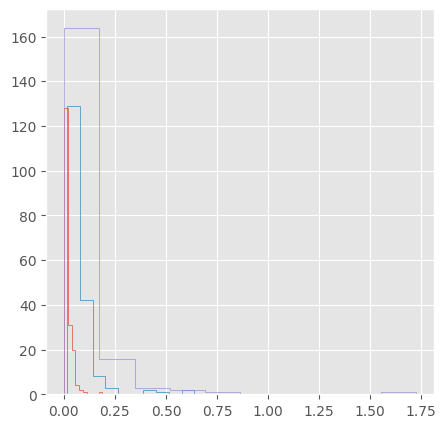

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.hist(df_shp_eora['S1_ext_total'], histtype = 'step')
plt.hist(df_shp_eora['S2_ext_total'], histtype = 'step')
plt.hist(df_shp_eora['S3_ext_total'], histtype = 'step')

In [ ]:
print(min(df_shp_eora['S1_ext_total']),max(df_shp_eora['S1_ext_total']))
print(min(df_shp_eora['S2_ext_total']),max(df_shp_eora['S2_ext_total']))
print(min(df_shp_eora['S3_ext_total']),max(df_shp_eora['S3_ext_total']))

0.0 0.18870337634366277
0.01706071557333334 0.6385199823674816
0.0017889939955794082 1.7250694809842475


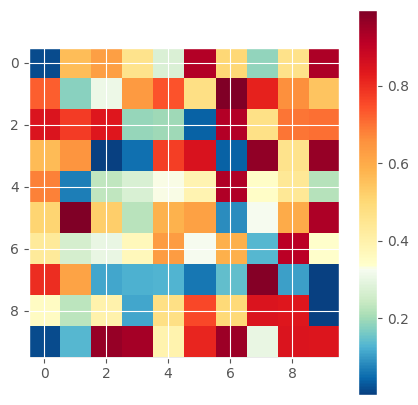

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap combining gist_earth and another colormap
colors1 = plt.cm.GnBu.reversed()(np.linspace(0, 1, 32))
colors2 = plt.cm.YlOrRd(np.linspace(0, 1, 64))


combined_colors = np.vstack((colors1, colors2))
combined_cmap = LinearSegmentedColormap.from_list('combined_cmap', combined_colors)
# combined_cmap
# # Create a sample data array
data = np.random.rand(10, 10)

# Plot the data with custom colorbar
fig = plt.figure(figsize=(5, 5))
plt.imshow(data, cmap=combined_cmap)
plt.colorbar()
plt.show()

In [ ]:
#@title Shift cmap
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    matplotlib.colormaps.register(newcmap)

    return newcmap

In [ ]:
colors1 = plt.cm.GnBu.reversed()(np.linspace(0, 1, 32))
colors2 = plt.cm.YlOrRd(np.linspace(0, 1, 128))
combined_colors = np.vstack((colors1, colors2))
combined_cmap = LinearSegmentedColormap.from_list('combined_cmap', combined_colors)

In [ ]:
min(df_shp_eora['diff_23']),max(df_shp_eora['diff_23'])

(-0.5704025315432469, 1.6212100783548808)

(array([  2.,   4., 155.,  20.,   3.,   2.,   0.,   0.,   0.,   1.]),
 array([-0.57040253, -0.35124127, -0.13208001,  0.08708125,  0.30624251,
         0.52540377,  0.74456503,  0.9637263 ,  1.18288756,  1.40204882,
         1.62121008]),
 <BarContainer object of 10 artists>)

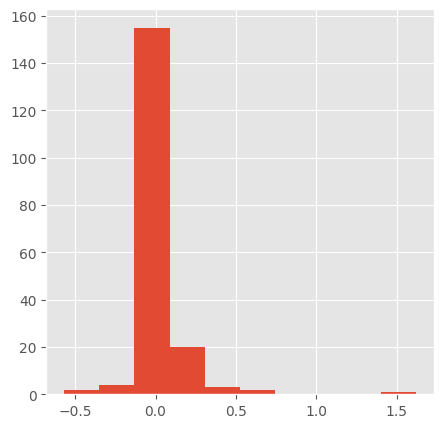

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.hist(df_shp_eora['diff_23'])

In [ ]:
shifted_cmap_eora = shiftedColorMap(matplotlib.cm.PiYG, midpoint=0.5/(0.5+0.5) ,name='shifted_eora22') # ,name='shifted_eora'

(np.float64(0.13653052322347414), np.float64(0.5098076923076923), np.float64(0.36443895355305167), np.float64(0.3701923076923077))


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


(np.float64(0.5240305232234741), np.float64(0.5098076923076923), np.float64(0.36443895355305167), np.float64(0.3701923076923077))
(np.float64(0.13653052322347414), np.float64(0.10999999999999999), np.float64(0.36443895355305167), np.float64(0.3701923076923077))
(np.float64(0.5240305232234741), np.float64(0.10999999999999999), np.float64(0.36443895355305167), np.float64(0.3701923076923077))


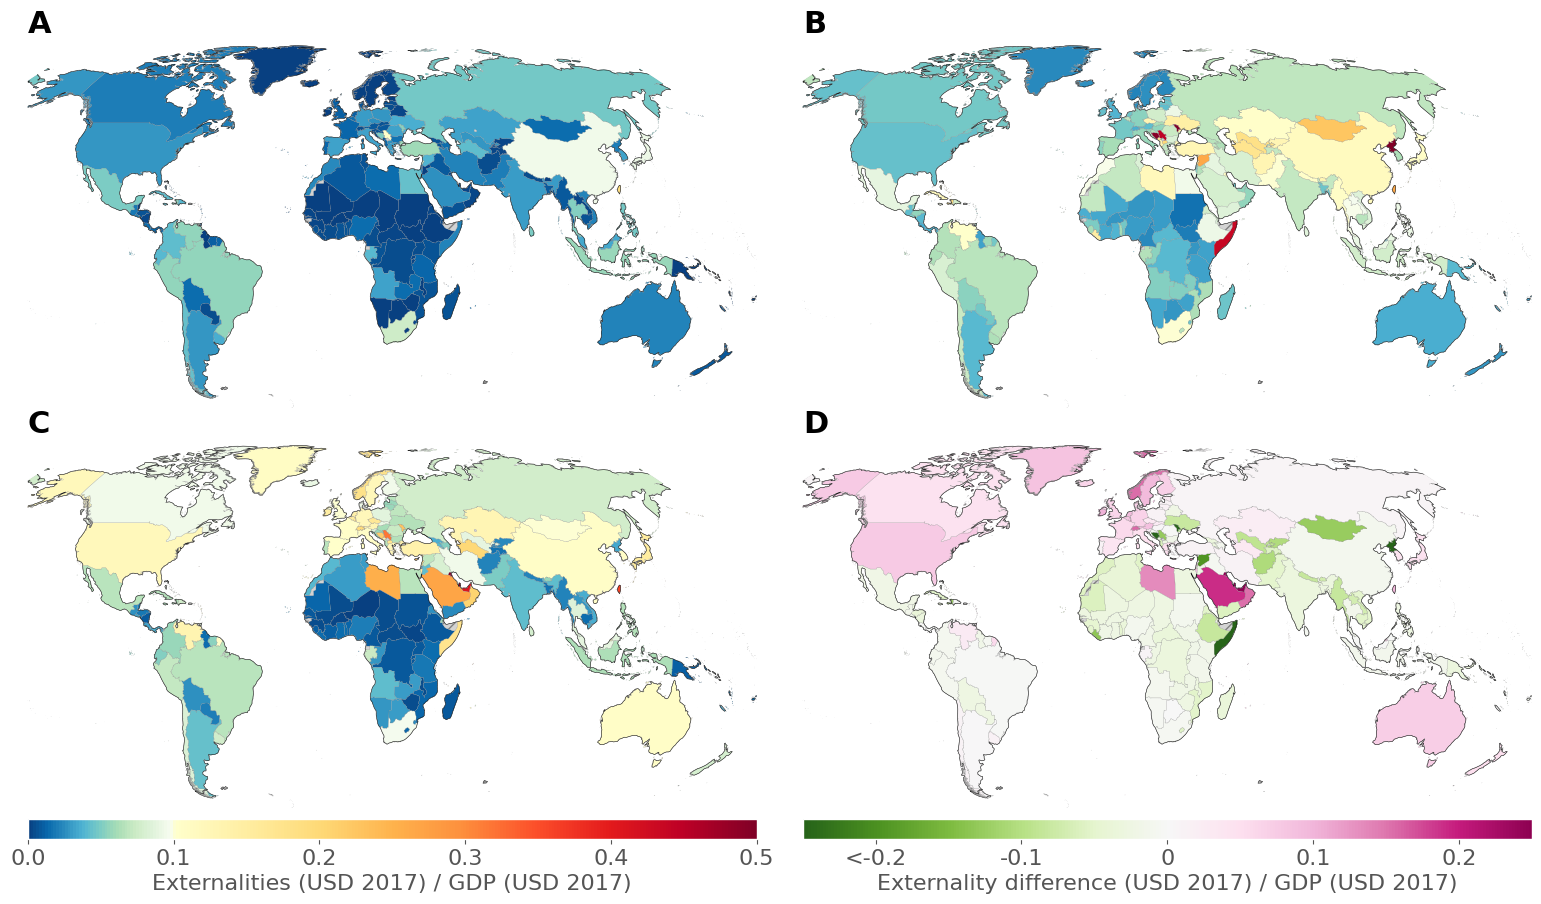

In [ ]:
# plot_columns_eora = ['S1_ext_total_log','S2_ext_total_log','S3_ext_total_log','diff_12_log']
plot_columns_eora = ['S1_ext_total','S2_ext_total','S3_ext_total','diff_23']

# Create a figure and a set of subplots
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 2, wspace=0,hspace=0.08)
# gs.update(hspace=0.001, wspace=0.001)

map_extent = [-135, 180, -60, 90]  # [lonmin, lonmax, latmin, latmax]

# Create subplots with Robinson projection
for i in range(4):
    ax = plt.subplot(gs[i], projection=ccrs.Robinson())
    ax.set_title(f"{string.ascii_uppercase[i]}", loc='left', pad=-0.5, fontsize=22,fontweight='bold')

    # Plot the data
    if i <= 2:
      df_shp_eora.to_crs(ccrs.Robinson()).plot(
          linewidths=0, column=plot_columns_eora[i], ax=ax, vmin=0, vmax=0.5, legend=False,
          cmap=combined_cmap, missing_kwds={
              "color": "lightgrey",
              "edgecolor": "grey",
              "hatch": "///",
              "label": "Missing values",
          }
      )
      df_shp_eora.to_crs(ccrs.Robinson()).boundary.plot(ax=ax, linewidth=0.1, edgecolor='grey')
      ax.set_extent(map_extent, crs=ccrs.PlateCarree())



    if i == 3:
      df_shp_eora.to_crs(ccrs.Robinson()).plot(
          linewidths=0, column=plot_columns_eora[i], ax=ax, vmin=-0.25, vmax=0.25, legend=False,
          cmap=shifted_cmap_eora.reversed(),missing_kwds={
              "color": "lightgrey",
              "edgecolor": "grey",
              "hatch": "///",
              "label": "Missing values",
          }
      )
      df_shp_eora.to_crs(ccrs.Robinson()).boundary.plot(ax=ax, linewidth=0.1, edgecolor='grey')
      ax.set_extent(map_extent, crs=ccrs.PlateCarree())



    print(ax.get_position().bounds)
    # Customize colorbar: Horizontal
    if i == 2:
        l2, b2, w2, h2 = ax.get_position().bounds # position of the second plot, and I want the first color bar right below the third plot
        c_w = w2 # colorbar width
        c_h = 0.02 # colorbar height
        c_b = b2 - 0.03  # colorbar bottom
        c_l = l2 # colorbar left
        cbar_ax1 = fig.add_axes([c_l,c_b,c_w,c_h])
        cbar1 = fig.colorbar(ax.collections[0], cax=cbar_ax1, shrink=0.5, orientation='horizontal')
        # cbar1.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        cbar1.ax.tick_params(labelsize=16)
        cbar1.set_label('Externalities (USD 2017) / GDP (USD 2017)', fontsize=16)
        # Set custom tick labels for colorbar
        # cbar1.ax.set_xticklabels(['10$^{7}$', '10$^{8}$', '10$^{9}$', '10$^{10}$', '10$^{11}$', '10$^{12}$']) # multiply everything by 1e6 and change the legend to just "USD YYYY"



    elif i == 3:
        l3, b3, w3, h3 = ax.get_position().bounds # position of the last plot, and I want the second color bar right below the last plot

        c_w = w3 # colorbar width
        c_h = 0.02 # colorbar height
        c_b = b3 - 0.03  # colorbar bottom
        c_l = l3 # colorbar left
        cbar_ax1 = fig.add_axes([c_l,c_b,c_w,c_h])
        cbar1 = fig.colorbar(ax.collections[0], cax=cbar_ax1, shrink=0.5, orientation='horizontal')
        cbar1.set_ticks([-0.2, -0.1, 0, 0.1, 0.2])
        cbar1.ax.tick_params(labelsize=16)
        cbar1.set_label('Externality difference (USD 2017) / GDP (USD 2017)', fontsize=16)
        # Set custom tick labels for colorbar
        cbar1.ax.set_xticklabels(['<-0.2','-0.1','0','0.1','0.2'])
        # cbar1.ax.set_xticklabels(['-10$^{10}$','-10$^{8}$','0','10$^{8}$','10$^{10}$','10$^{12}$']) # multiply everything by 1e6 and change the legend to just "USD YYYY"


    # Add coastlines and gridlines
    ax.coastlines(linewidths=0.4)
    # gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      # linewidth=2, color='gray', alpha=0.5, linestyle='--')
    # gl.xlabel_style = {'size': 12, 'color': 'gray'}
    # gl.ylabel_style = {'size': 12, 'color': 'gray'}

    plt.rcParams['axes.facecolor'] = 'white'

    ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
# Save the figure as a PDF
plt.savefig("First_review_plot/Fig4_EORA.pdf", format='pdf', dpi=300, bbox_inches='tight')
# plt.tight_layout()
plt.show()


In [ ]:
df_shp_eora[df_shp_eora['population'] > 10000000]

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,S3_ext_money,S1_ext_total,S2_ext_total,S3_ext_total,diff_12,diff_13,diff_23,diff_23_money,population,gdp_capita
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,6.131358e+10,0.056688,0.077250,0.063818,0.020561,0.007130,-0.013432,-1.290452e+10,2.766634e+08,3472.645480
1,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,2.508897e+10,0.034945,0.089996,0.089650,0.055052,0.054706,-0.000346,-9.686358e+07,3.372417e+07,8298.311671
2,Admin-0 country,6,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,2.169355e+10,0.044732,0.072807,0.083826,0.028075,0.039094,0.011020,2.851757e+09,1.982289e+07,13055.194034
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,1.025399e+09,0.015347,0.053146,0.026696,0.037798,0.011348,-0.026450,-1.015964e+09,1.145859e+07,3352.128183
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,1.351055e+10,0.056322,0.080439,0.071724,0.024117,0.015402,-0.008715,-1.641589e+09,3.402639e+07,5535.954669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,Admin-0 country,0,3,Madagascar,MDG,0,2,Sovereign country,Madagascar,MDG,...,1.043270e+08,0.006025,0.044973,0.008968,0.038948,0.002943,-0.036005,-4.188668e+08,2.586903e+07,449.708462
179,Admin-0 country,6,2,Philippines,PHL,0,2,Sovereign country,Philippines,PHL,...,2.304203e+10,0.048700,0.093066,0.065972,0.044367,0.017272,-0.027094,-9.463205e+09,1.048271e+08,3331.860777
180,Admin-0 country,0,3,Sri Lanka,LKA,0,2,Sovereign country,Sri Lanka,LKA,...,6.957212e+09,0.050263,0.086635,0.079414,0.036371,0.029151,-0.007221,-6.325744e+08,2.122934e+07,4126.692490
185,Admin-0 country,0,3,Taiwan,TWN,0,2,Sovereign country,Taiwan,TWN,...,6.087791e+10,0.188703,0.262389,0.359777,0.073686,0.171074,0.097388,1.647903e+10,2.412668e+07,7013.403516


# 2. GTAP

In [ ]:
# @title Read files
# VSL
file = open("Data/VSL_dict_gtap.json", "r")
VSL_gtap = file.read()
VSL_gtap = json.loads(VSL_gtap)

for country in VSL_gtap:
  VSL_gtap[country] = VSL_gtap[country] * 1.04 * 1000000 # unit:usd

file = open("First_review_data/Total_pop_gtap.json", "r")
population_gtap = file.read()
population_gtap = json.loads(population_gtap)

# total number of deaths caused by country i and happen in country j
con_mort_tol_gtap = pd.read_csv('First_review_data/S3.csv',index_col=0)
con_mort_tol_gtap = {col: con_mort_tol_gtap[col].to_dict() for col in con_mort_tol_gtap.columns}

file = open("Data/GDP_gtap_dict.json", "r")
gdp_gtap = file.read()
gdp_gtap = json.loads(gdp_gtap) # unit:usd

In [ ]:
dict(sorted(gdp_gtap.items(), key=lambda item: item[1]))

{'XTW': 167000000,
 'XCA': 1718000000,
 'TGO': 4482000000,
 'MWI': 6048000000,
 'XSC': 6594000000,
 'GIN': 6625000000,
 'KGZ': 7468000000,
 'RWA': 7913000000,
 'XEE': 7983000000,
 'XNA': 8047000000,
 'TJK': 9236000000,
 'BEN': 9575000000,
 'MLT': 10536000000,
 'MDG': 11011000000,
 'ARM': 11644000000,
 'LAO': 11716000000,
 'NIC': 11790000000,
 'MNG': 12226000000,
 'BFA': 12549000000,
 'MUS': 12613000000,
 'NAM': 12838000000,
 'ALB': 13278000000,
 'XSM': 13569000000,
 'JAM': 13927000000,
 'ZWE': 14197000000,
 'SEN': 15658000000,
 'BWA': 15880000000,
 'GEO': 16509000000,
 'KHM': 16778000000,
 'MOZ': 16946000000,
 'BRN': 17105000000,
 'HND': 19380000000,
 'NPL': 19770000000,
 'XEF': 22891000000,
 'CYP': 23227000000,
 'SLV': 25054000000,
 'XSA': 25073000000,
 'EST': 26485000000,
 'ZMB': 26963000000,
 'UGA': 26999000000,
 'TTO': 28874000000,
 'PRY': 30881000000,
 'LVA': 31283000000,
 'CMR': 32051000000,
 'BOL': 32996000000,
 'BHR': 33851000000,
 'CIV': 34253000000,
 'JOR': 35827000000,
 'GHA

In [ ]:
16772079/1000000

16.772079

In [ ]:
gdp_gtap['USA'], VSL_gtap['USA']

(17348106000000, 10016240.0)

## 2.1 Scenario 1: Zero VSL for other countries

In [ ]:
# @title Externality_A = a × VSL_A
S1_ext_total_gtap = {}
for country_i in con_mort_tol_gtap:
#     print(country_i,con_mort_tol[country_i][country_i],VSL[country_i])
    S1_ext_total_gtap[country_i] = con_mort_tol_gtap[country_i][country_i] * VSL_gtap[country_i]

S1_ratio = {}
for i in S1_ext_total_gtap:
  if i != 'XTW':
    S1_ratio[i] = S1_ext_total_gtap[i] / gdp_gtap[i]

## 2.2 Scenario 2: Different VSLs for different countries

In [ ]:
# @title Externality_A = a × VSL_A + b × VSL_B + c × VSL_C + d × VSL_D
S2_ext_gtap = {}
for country_i in con_mort_tol_gtap:
    S2_ext_gtap[country_i] = {}
    for country_j in con_mort_tol_gtap[country_i]:
        S2_ext_gtap[country_i][country_j] = con_mort_tol_gtap[country_i][country_j] * VSL_gtap[country_j]
S2_ext_total_gtap = {}
for country in S2_ext_gtap:
    S2_ext_total_gtap[country] = dictsum(S2_ext_gtap[country])

S2_ratio = {}
for i in S2_ext_total_gtap:
  if i != 'XTW':
    S2_ratio[i] = S2_ext_total_gtap[i] / gdp_gtap[i]

diff_12_gtap = {}
for i in S2_ext_total_gtap:
     diff_12_gtap[i] = (S2_ext_total_gtap[i] - S1_ext_total_gtap[i])

## 2.3 Scenario 3: Same VSL as the consumer

In [ ]:
# @title Externality_A = (a + b + c + d) × VSL_A
S3_ext_total_gtap = {}
for country_i in con_mort_tol_gtap:
    S3_ext_total_gtap[country_i] = dictsum(con_mort_tol_gtap[country_i]) * VSL_gtap[country_i]

diff_23_gtap = {}
for i in S3_ext_total_gtap:
     diff_23_gtap[i] = (S3_ext_total_gtap[i] - S2_ext_total_gtap[i])

diff_13_gtap = {}
for i in S3_ext_total_gtap:
     diff_13_gtap[i] = (S3_ext_total_gtap[i] - S1_ext_total_gtap[i])

S3_ratio = {}
for i in S3_ext_total_gtap:
  if i != 'XTW':
    S3_ratio[i] = S3_ext_total_gtap[i] / gdp_gtap[i]
diff_ratio = {}
for i in diff_23_gtap:
  if i != 'XTW':
    diff_ratio[i] = diff_23_gtap[i] / gdp_gtap[i]

In [ ]:
S1_ratio['USA'],S1_ratio['DEU'],S1_ratio['FRA']

(0.031250078885713246, 0.023575059498414184, 0.009827496316443172)

In [ ]:
S2_ratio['USA'],S2_ratio['DEU'],S2_ratio['FRA']

(0.05129684384900626, 0.05108845996240062, 0.04717686338448236)

In [ ]:
S3_ratio['USA'],S3_ratio['DEU'],S3_ratio['FRA']

(0.14188337870444306, 0.1331636578893528, 0.10798389293441761)

In [ ]:
dict(sorted(S1_ratio.items(), key=lambda item: item[1]))

{'XEF': 0.0,
 'XNA': 0.0,
 'XOC': 2.323237508087508e-05,
 'XSM': 2.7516624566688317e-05,
 'XCA': 4.09584287180681e-05,
 'XWF': 0.00034792534567369546,
 'NOR': 0.0004915101646731449,
 'SWE': 0.0006834229739030422,
 'PRI': 0.0007452882063701759,
 'BFA': 0.0007871059521400175,
 'IRL': 0.0008225995326828556,
 'BHR': 0.0008477191396891146,
 'XSC': 0.0008920723780183139,
 'KWT': 0.0009355946718483915,
 'EST': 0.001092844606738074,
 'XEC': 0.0011785520762674336,
 'BWA': 0.0011844604328158752,
 'XCF': 0.0011985189423867593,
 'XSE': 0.0013047561503289394,
 'TJK': 0.0013120203240173539,
 'LUX': 0.0014423544095588854,
 'QAT': 0.001516287804064696,
 'MWI': 0.0015368729878613842,
 'OMN': 0.0015915312218981602,
 'MOZ': 0.001781411901068197,
 'GIN': 0.0019037380501731322,
 'FIN': 0.0019717833859413778,
 'ZWE': 0.0019917301189250353,
 'NAM': 0.0020810201671003776,
 'JOR': 0.0027776030059746444,
 'TGO': 0.0030244505853974065,
 'XNF': 0.003026073349361258,
 'BRN': 0.003035028954680228,
 'XWS': 0.0030687

In [ ]:
# @title 2.4 Plot preparation for different scenarios
df_shp_gtap = gpd.read_file('Data/10m_cultural/ne_10m_admin_0_countries.shp')

df_shp_gtap["VSL"] = np.nan

df_shp_gtap["S1_ext_money"] = np.nan
df_shp_gtap["S2_ext_money"] = np.nan
df_shp_gtap["S3_ext_money"] = np.nan

df_shp_gtap["S1_ext_total"] = np.nan
df_shp_gtap["S2_ext_total"] = np.nan
df_shp_gtap["S3_ext_total"] = np.nan

df_shp_gtap["diff_12"] = np.nan
df_shp_gtap["diff_13"] = np.nan
df_shp_gtap["diff_23"] = np.nan
df_shp_gtap["diff_23_money"] = np.nan

df_shp_gtap["population"] = np.nan


Gtap_regions = {'PRI':['PRI'],
               'XCB':['AIA','ATG','ABW','BHS','BRB','VGB','CYM','CUB','DMA','GRD','HTI','MSR','KNA','LCA','VCT','TCA','VIR'],
               'XCF':['CAF','TCD','COG','GNQ','GAB','STP'],
               'XEC':['BDI','COM','DJI','ERI','SYC','SOM','SDN'], # gtap ONLY contains Sudan, without South Sudan
               'XER':['AND','BIH','GIB','GGY','VAT','IMN','JEY','MKD','MCO','MNE','SMR','SRB'],
               'XNA':['BMU','GRL','SPM'],
               'XNF':['DZA','LBY','SAH','ESH'], # 'SAH' is changed from 'ESH': Western Sahara
               'XOC':['ASM','COK','FJI','PYF','GUM','KIR','MHL','FSM','NRU','NCL','NIU','MNP','PLW','PNG','PCN','WSM','SLB',
                      'TON','TUV','VUT','WLF'], #'TKL' Tokelau is removed since it's counted as New Zealand
               'XSE':['MMR','TLS'],
               'XSM':['FLK','GUY','SUR'],
               'XWF':['CPV','GMB','GNB','LBR','MLI','MRT','NER','SHN','SLE'],
               'XAC':['AGO','COD'],
               'XEA':['PRK','MAC'],
               'XSA':['AFG','BTN','MDV'],
               'XSC':['LSO','SWZ'],
               'XSU':['TJK','TKM','UZB'],
               'XWS':['IRQ','LBN','PSX','YEM','SYR'],
               'XEF':['ISL','LIE'],
               'XCA':['BLZ'],
               'XEE':['MDA']}
                #XTW # the rest of the world

for i in con_mort_tol_gtap:
    if i[0] != 'X':
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"VSL"] = VSL_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"S1_ext_total"] = S1_ext_total_gtap[i] / gdp_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"S2_ext_total"] = S2_ext_total_gtap[i] / gdp_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"S3_ext_total"] = S3_ext_total_gtap[i] / gdp_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"S1_ext_money"] = S1_ext_total_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"S2_ext_money"] = S2_ext_total_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"S3_ext_money"] = S3_ext_total_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"diff_23"] = diff_23_gtap[i] / gdp_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"diff_13"] = diff_13_gtap[i] / gdp_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"diff_12"] = diff_12_gtap[i] / gdp_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"diff_23_money"] = diff_23_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"population"] = population_gtap[i]
        df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == i,"gdp_capita"] = gdp_gtap[i] / population_gtap[i]
    elif i[0] == 'X' and i != 'XTW': # Assign the value of the region to its member countries
        for j in Gtap_regions[i]:
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"VSL"] = VSL_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"S1_ext_total"] = S1_ext_total_gtap[i] / gdp_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"S2_ext_total"] = S2_ext_total_gtap[i] / gdp_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"S3_ext_total"] = S3_ext_total_gtap[i] / gdp_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"S1_ext_money"] = S1_ext_total_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"S2_ext_money"] = S2_ext_total_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"S3_ext_money"] = S3_ext_total_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"diff_23"] = diff_23_gtap[i] / gdp_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"diff_12"] = diff_12_gtap[i] / gdp_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"diff_13"] = diff_13_gtap[i] / gdp_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"diff_23_money"] = diff_23_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"population"] = population_gtap[i]
            df_shp_gtap.loc[df_shp_gtap['ADM0_A3'] == j,"gdp_capita"] = gdp_gtap[i] / population_gtap[i]

# df_shp_gtap['S1_ext_total_log'] = np.log10(df_shp_gtap['S1_ext_total'])
# df_shp_gtap['S2_ext_total_log'] = np.log10(df_shp_gtap['S2_ext_total'])
# df_shp_gtap['S3_ext_total_log'] = np.log10(df_shp_gtap['S3_ext_total'])
# df_shp_gtap['diff_12_log'] = [np.log10(df_shp_gtap.loc[i,'diff_12']) if df_shp_gtap.loc[i,'diff_12'] >= 0 else -np.log10(-df_shp_gtap.loc[i,'diff_12']) for i in range(len(df_shp_gtap))]

In [ ]:
df_shp_eora_new = df_shp_eora[['ADM0_A3','VSL','S1_ext_money','S2_ext_money','S3_ext_money','S1_ext_total','S2_ext_total','S3_ext_total','diff_12','diff_13','diff_23']]

In [ ]:
df_shp_eora_new.columns = ['Country','VSL','BAU_Externality','GC_Externality','FTD_Externality','BAU_Ext_perGDP','GC_Ext_perGDP','FTD_Ext_perGDP','Diff_GC_BAU','Diff_FTD_BAU','Diff_FTD_GC']

In [ ]:
df_shp_gtap_new = df_shp_gtap[['ADM0_A3','VSL','S1_ext_money','S2_ext_money','S3_ext_money','S1_ext_total','S2_ext_total','S3_ext_total','diff_12','diff_13','diff_23']]

In [ ]:
df_shp_gtap_new.columns = ['Country','VSL','BAU_Externality','GC_Externality','FTD_Externality','BAU_Ext_perGDP','GC_Ext_perGDP','FTD_Ext_perGDP','Diff_GC_BAU','Diff_FTD_BAU','Diff_FTD_GC']

In [ ]:
df_shp_eora_new = df_shp_eora_new[df_shp_eora_new['VSL'].notna()].reset_index(drop=True)

In [ ]:
df_shp_gtap_new = df_shp_gtap_new[df_shp_gtap_new['VSL'].notna()].reset_index(drop=True)

In [ ]:
df_shp_gtap_new.sort_values(by='Country',ascending=True,inplace=True)

In [ ]:
df_shp_gtap_new = df_shp_gtap_new.reset_index(drop=True)

In [ ]:
df_shp_eora_new.sort_values(by='Country',ascending=True,inplace=True)

In [ ]:
df_shp_eora_new = df_shp_eora_new .reset_index(drop=True)

In [ ]:
df_shp_eora_new[df_shp_eora_new['Country'] == 'PSX']

,Country,VSL,BAU_Externality,GC_Externality,FTD_Externality,BAU_Ext_perGDP,GC_Ext_perGDP,FTD_Ext_perGDP,Diff_GC_BAU,Diff_FTD_BAU,Diff_FTD_GC
139,PSX,553280.0,2.535159e+07,8.203041e+08,2.561983e+08,0.001238,0.040044,0.012507,0.038807,0.011269,-0.027538


In [ ]:
df_shp_eora_new[df_shp_eora_new['Country'] == 'SDN']

,Country,VSL,BAU_Externality,GC_Externality,FTD_Externality,BAU_Ext_perGDP,GC_Ext_perGDP,FTD_Ext_perGDP,Diff_GC_BAU,Diff_FTD_BAU,Diff_FTD_GC
146,SDN,343200.0,1.892652e+08,1.947682e+09,7.477280e+08,0.001658,0.017061,0.00655,0.015403,0.004892,-0.010511


In [ ]:
df_shp_eora_new.loc[146,'Country'] = 'SUD'

In [ ]:
df_shp_eora_new.loc[139,'Country'] = 'PSE'

In [ ]:
df_shp_eora_new[df_shp_eora_new['Country'] == 'PSE']

,Country,VSL,BAU_Externality,GC_Externality,FTD_Externality,BAU_Ext_perGDP,GC_Ext_perGDP,FTD_Ext_perGDP,Diff_GC_BAU,Diff_FTD_BAU,Diff_FTD_GC
139,PSE,553280.0,2.535159e+07,8.203041e+08,2.561983e+08,0.001238,0.040044,0.012507,0.038807,0.011269,-0.027538


In [ ]:
df_shp_gtap_new.to_csv("First_review_data/S11.csv")

In [ ]:
df_shp_eora_new.to_csv("First_review_data/S12.csv")

In [ ]:
A = pd.read_csv('Data/S12.csv')

In [ ]:
A

,Unnamed: 0,Country,VSL,BAU_Externality,GC_Externality,FTD_Externality,BAU_Ext_perGDP,GC_Ext_perGDP,FTD_Ext_perGDP,Diff_GC_BAU,Diff_FTD_BAU,Diff_FTD_GC
0,0,ABW,6.394791e+06,1.908876e+04,9.670371e+07,3.273447e+08,0.000008,0.039931,0.135166,0.039923,0.135159,0.095236
1,1,AFG,1.092000e+05,1.161978e+08,3.737257e+09,6.348092e+08,0.004632,0.148984,0.025306,0.144352,0.020674,-0.123678
2,2,AGO,7.477600e+05,4.824014e+09,8.108790e+09,6.405063e+09,0.044180,0.074263,0.058660,0.030083,0.014480,-0.015603
3,3,ALB,7.654400e+05,2.272002e+08,2.050604e+09,9.169475e+08,0.016357,0.147635,0.066016,0.131277,0.049659,-0.081618
4,4,AND,7.741760e+06,1.121080e+06,9.943746e+07,3.892041e+08,0.000398,0.035337,0.138311,0.034938,0.137912,0.102974
...,...,...,...,...,...,...,...,...,...,...,...,...
182,182,WSM,7.030400e+05,0.000000e+00,4.514869e+07,2.343342e+07,0.000000,0.050508,0.026215,0.050508,0.026215,-0.024293
183,183,YEM,2.038400e+05,2.678309e+08,2.890833e+09,8.419994e+08,0.009093,0.098148,0.028587,0.089055,0.019494,-0.069561
184,184,ZAF,1.087840e+06,2.753560e+10,3.673371e+10,3.543813e+10,0.084752,0.113063,0.109075,0.028311,0.024323,-0.003988
185,185,ZMB,2.662400e+05,3.873275e+08,1.459659e+09,8.284547e+08,0.015870,0.059806,0.033944,0.043936,0.018074,-0.025862


------

In [ ]:
df_shp_gtap[df_shp_gtap['population']>100000000].sort_values(by='diff_23',ascending=True)[:6]

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,S3_ext_money,S1_ext_total,S2_ext_total,S3_ext_total,diff_12,diff_13,diff_23,diff_23_money,population,gdp_capita
17,Admin-0 country,0,2,Pakistan,PAK,0,2,Sovereign country,Pakistan,PAK,...,1.634729e+10,0.025225,0.145541,0.067167,0.120316,0.041942,-0.078374,-1.907499e+10,2.222853e+08,1094.912585
127,Admin-0 country,0,3,Bangladesh,BGD,0,2,Sovereign country,Bangladesh,BGD,...,4.830648e+09,0.012698,0.083811,0.027941,0.071113,0.015243,-0.055869,-9.658955e+09,1.643525e+08,1051.915559
13,Admin-0 country,0,2,Ethiopia,ETH,0,2,Sovereign country,Ethiopia,ETH,...,4.831606e+08,0.003837,0.055077,0.008688,0.051240,0.004851,-0.046389,-2.579792e+09,1.080649e+08,514.616685
8,Admin-0 country,0,2,India,IND,0,2,Sovereign country,India,IND,...,1.017372e+11,0.036116,0.087525,0.049812,0.051409,0.013695,-0.037713,-7.702721e+10,1.401273e+09,1457.561884
179,Admin-0 country,6,2,Philippines,PHL,0,2,Sovereign country,Philippines,PHL,...,2.109552e+10,0.049515,0.110939,0.074077,0.061423,0.024562,-0.036861,-1.049730e+10,1.102084e+08,2583.986688
12,Admin-0 country,0,5,Lebanon,LBN,0,2,Sovereign country,Lebanon,LBN,...,8.813179e+09,0.003069,0.054443,0.024948,0.051375,0.021879,-0.029496,-1.041998e+10,1.180665e+08,2992.119168


In [ ]:
df_shp_eora[df_shp_eora['population']>100000000].sort_values(by='diff_23',ascending=True)[:20]

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,S3_ext_money,S1_ext_total,S2_ext_total,S3_ext_total,diff_12,diff_13,diff_23,diff_23_money,population,gdp_capita
17,Admin-0 country,0,2,Pakistan,PAK,0,2,Sovereign country,Pakistan,PAK,...,1.551586e+10,0.019643,0.100286,0.050149,0.080643,0.030506,-0.050137,-1.551204e+10,2.191843e+08,1411.573545
32,Admin-0 country,0,2,Democratic Republic of the Congo,COD,0,2,Sovereign country,Democratic Republic of the Congo,COD,...,2.849808e+08,0.005363,0.039914,0.008079,0.034552,0.002716,-0.031836,-1.123032e+09,1.030583e+08,342.290034
8,Admin-0 country,0,2,India,IND,0,2,Sovereign country,India,IND,...,9.834137e+10,0.030810,0.070682,0.041275,0.039871,0.010465,-0.029406,-7.006237e+10,1.366845e+09,1743.113709
127,Admin-0 country,0,3,Bangladesh,BGD,0,2,Sovereign country,Bangladesh,BGD,...,4.208207e+09,0.007996,0.045655,0.017091,0.037658,0.009095,-0.028563,-7.032884e+09,1.588812e+08,1549.709701
179,Admin-0 country,6,2,Philippines,PHL,0,2,Sovereign country,Philippines,PHL,...,2.304203e+10,0.048700,0.093066,0.065972,0.044367,0.017272,-0.027094,-9.463205e+09,1.048271e+08,3331.860777
155,Admin-0 country,0,2,Mexico,MEX,0,2,Sovereign country,Mexico,MEX,...,7.454725e+10,0.048963,0.089631,0.068348,0.040668,0.019385,-0.021283,-2.321318e+10,1.368668e+08,7969.082513
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,6.131358e+10,0.056688,0.077250,0.063818,0.020561,0.007130,-0.013432,-1.290452e+10,2.766634e+08,3472.645480
9,Admin-0 country,0,2,China,CH1,1,2,Country,China,CHN,...,1.197898e+12,0.093937,0.116431,0.105740,0.022493,0.011803,-0.010691,-1.211099e+11,1.429385e+09,7925.580878
100,Admin-0 country,0,2,Nigeria,NGA,0,2,Sovereign country,Nigeria,NGA,...,7.490047e+09,0.014332,0.031083,0.020935,0.016751,0.006603,-0.010149,-3.631018e+09,2.011856e+08,1778.366490
45,Admin-0 country,0,2,Brazil,BRA,0,2,Sovereign country,Brazil,BRA,...,1.290272e+11,0.055836,0.067413,0.066710,0.011577,0.010873,-0.000704,-1.361281e+09,2.124923e+08,9102.268841


In [ ]:
df_shp_eora[df_shp_eora['population']>100000000].sort_values(by='S1_ext_total',ascending=True)[:8]

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,S3_ext_money,S1_ext_total,S2_ext_total,S3_ext_total,diff_12,diff_13,diff_23,diff_23_money,population,gdp_capita
32,Admin-0 country,0,2,Democratic Republic of the Congo,COD,0,2,Sovereign country,Democratic Republic of the Congo,COD,...,2.849808e+08,0.005363,0.039914,0.008079,0.034552,0.002716,-0.031836,-1.123032e+09,1.030583e+08,342.290034
127,Admin-0 country,0,3,Bangladesh,BGD,0,2,Sovereign country,Bangladesh,BGD,...,4.208207e+09,0.007996,0.045655,0.017091,0.037658,0.009095,-0.028563,-7.032884e+09,1.588812e+08,1549.709701
100,Admin-0 country,0,2,Nigeria,NGA,0,2,Sovereign country,Nigeria,NGA,...,7.490047e+09,0.014332,0.031083,0.020935,0.016751,0.006603,-0.010149,-3.631018e+09,2.011856e+08,1778.366490
17,Admin-0 country,0,2,Pakistan,PAK,0,2,Sovereign country,Pakistan,PAK,...,1.551586e+10,0.019643,0.100286,0.050149,0.080643,0.030506,-0.050137,-1.551204e+10,2.191843e+08,1411.573545
153,Admin-0 country,0,2,United States of America,US1,1,2,Country,United States of America,USA,...,2.393151e+12,0.028059,0.044018,0.121059,0.015959,0.093000,0.077041,1.522989e+12,3.386301e+08,58377.664665
8,Admin-0 country,0,2,India,IND,0,2,Sovereign country,India,IND,...,9.834137e+10,0.030810,0.070682,0.041275,0.039871,0.010465,-0.029406,-7.006237e+10,1.366845e+09,1743.113709
48,Admin-0 country,0,2,Russia,RUS,0,2,Sovereign country,Russia,RUS,...,1.049244e+11,0.047008,0.069749,0.077201,0.022740,0.030192,0.007452,1.012823e+10,1.434064e+08,9477.352998
179,Admin-0 country,6,2,Philippines,PHL,0,2,Sovereign country,Philippines,PHL,...,2.304203e+10,0.048700,0.093066,0.065972,0.044367,0.017272,-0.027094,-9.463205e+09,1.048271e+08,3331.860777


In [ ]:
df_shp_gtap[df_shp_gtap['population']>100000000].sort_values(by='S1_ext_total',ascending=True)[:14]

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,S3_ext_money,S1_ext_total,S2_ext_total,S3_ext_total,diff_12,diff_13,diff_23,diff_23_money,population,gdp_capita
11,Admin-0 country,0,5,Israel,IS1,1,2,Disputed,Palestine,PSX,...,8.813179e+09,0.003069,0.054443,0.024948,0.051375,0.021879,-0.029496,-1.041998e+10,1.180665e+08,2992.119168
12,Admin-0 country,0,5,Lebanon,LBN,0,2,Sovereign country,Lebanon,LBN,...,8.813179e+09,0.003069,0.054443,0.024948,0.051375,0.021879,-0.029496,-1.041998e+10,1.180665e+08,2992.119168
20,Admin-0 country,0,3,Syria,SYR,0,2,Sovereign country,Syria,SYR,...,8.813179e+09,0.003069,0.054443,0.024948,0.051375,0.021879,-0.029496,-1.041998e+10,1.180665e+08,2992.119168
90,Admin-0 country,0,3,Iraq,IRQ,0,2,Sovereign country,Iraq,IRQ,...,8.813179e+09,0.003069,0.054443,0.024948,0.051375,0.021879,-0.029496,-1.041998e+10,1.180665e+08,2992.119168
161,Admin-0 country,0,3,Yemen,YEM,0,2,Sovereign country,Yemen,YEM,...,8.813179e+09,0.003069,0.054443,0.024948,0.051375,0.021879,-0.029496,-1.041998e+10,1.180665e+08,2992.119168
13,Admin-0 country,0,2,Ethiopia,ETH,0,2,Sovereign country,Ethiopia,ETH,...,4.831606e+08,0.003837,0.055077,0.008688,0.051240,0.004851,-0.046389,-2.579792e+09,1.080649e+08,514.616685
102,Admin-0 country,0,3,Angola,AGO,0,2,Sovereign country,Angola,AGO,...,2.194137e+09,0.003891,0.039986,0.013751,0.036095,0.009861,-0.026234,-4.185895e+09,1.526424e+08,1045.305741
32,Admin-0 country,0,2,Democratic Republic of the Congo,COD,0,2,Sovereign country,Democratic Republic of the Congo,COD,...,2.194137e+09,0.003891,0.039986,0.013751,0.036095,0.009861,-0.026234,-4.185895e+09,1.526424e+08,1045.305741
100,Admin-0 country,0,2,Nigeria,NGA,0,2,Sovereign country,Nigeria,NGA,...,6.592837e+09,0.005298,0.024205,0.011597,0.018908,0.006299,-0.012608,-7.167680e+09,2.101482e+08,2705.205062
127,Admin-0 country,0,3,Bangladesh,BGD,0,2,Sovereign country,Bangladesh,BGD,...,4.830648e+09,0.012698,0.083811,0.027941,0.071113,0.015243,-0.055869,-9.658955e+09,1.643525e+08,1051.915559


In [ ]:
df_shp_gtap[df_shp_gtap['population']>100000000].sort_values(by='S2_ext_total',ascending=True)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,S3_ext_money,S1_ext_total,S2_ext_total,S3_ext_total,diff_12,diff_13,diff_23,diff_23_money,population,gdp_capita
100,Admin-0 country,0,2,Nigeria,NGA,0,2,Sovereign country,Nigeria,NGA,...,6.592837e+09,0.005298,0.024205,0.011597,0.018908,0.006299,-0.012608,-7.167680e+09,2.101482e+08,2705.205062
32,Admin-0 country,0,2,Democratic Republic of the Congo,COD,0,2,Sovereign country,Democratic Republic of the Congo,COD,...,2.194137e+09,0.003891,0.039986,0.013751,0.036095,0.009861,-0.026234,-4.185895e+09,1.526424e+08,1045.305741
102,Admin-0 country,0,3,Angola,AGO,0,2,Sovereign country,Angola,AGO,...,2.194137e+09,0.003891,0.039986,0.013751,0.036095,0.009861,-0.026234,-4.185895e+09,1.526424e+08,1045.305741
48,Admin-0 country,0,2,Russia,RUS,0,2,Sovereign country,Russia,RUS,...,1.058999e+11,0.024292,0.049594,0.052142,0.025303,0.027851,0.002548,5.174925e+09,1.433755e+08,14165.401445
153,Admin-0 country,0,2,United States of America,US1,1,2,Country,United States of America,USA,...,2.461408e+12,0.031250,0.051297,0.141883,0.020047,0.110633,0.090587,1.571505e+12,3.408780e+08,50892.418065
11,Admin-0 country,0,5,Israel,IS1,1,2,Disputed,Palestine,PSX,...,8.813179e+09,0.003069,0.054443,0.024948,0.051375,0.021879,-0.029496,-1.041998e+10,1.180665e+08,2992.119168
20,Admin-0 country,0,3,Syria,SYR,0,2,Sovereign country,Syria,SYR,...,8.813179e+09,0.003069,0.054443,0.024948,0.051375,0.021879,-0.029496,-1.041998e+10,1.180665e+08,2992.119168
12,Admin-0 country,0,5,Lebanon,LBN,0,2,Sovereign country,Lebanon,LBN,...,8.813179e+09,0.003069,0.054443,0.024948,0.051375,0.021879,-0.029496,-1.041998e+10,1.180665e+08,2992.119168
90,Admin-0 country,0,3,Iraq,IRQ,0,2,Sovereign country,Iraq,IRQ,...,8.813179e+09,0.003069,0.054443,0.024948,0.051375,0.021879,-0.029496,-1.041998e+10,1.180665e+08,2992.119168
161,Admin-0 country,0,3,Yemen,YEM,0,2,Sovereign country,Yemen,YEM,...,8.813179e+09,0.003069,0.054443,0.024948,0.051375,0.021879,-0.029496,-1.041998e+10,1.180665e+08,2992.119168


In [ ]:
df_shp_gtap_new = df_shp_gtap[df_shp_gtap['S1_ext_total'].notna()].reset_index()
df_shp_eora_new = df_shp_eora[df_shp_eora['S1_ext_total'].notna()].reset_index()

In [ ]:
df_shp_gtap[(df_shp_gtap['gdp_capita']<10000)&(df_shp_gtap['S1_ext_total'].notna())]['diff_23_money'].sum()/1000000000000

np.float64(-0.34549258336024397)

In [ ]:
df_shp_eora[(df_shp_eora['gdp_capita']<10000)&(df_shp_eora['S1_ext_total'].notna())]['diff_23_money'].sum()/1000000000000

np.float64(-0.36046943122739616)

In [ ]:
def population_averaged(df,column):
    weighted_sum = (df[column] * df['population']).sum()
    total_population = df['population'].sum()
    return weighted_sum / total_population

In [ ]:
population_averaged(df_shp_gtap_new,'S1_ext_total'),population_averaged(df_shp_eora_new,'S1_ext_total')

(np.float64(0.02941364469950851), np.float64(0.04182904953919524))

In [ ]:
population_averaged(df_shp_gtap_new,'S2_ext_total'),population_averaged(df_shp_eora_new,'S2_ext_total')

(np.float64(0.08089639159869), np.float64(0.0826909849893934))

In [ ]:
population_averaged(df_shp_gtap_new,'S3_ext_total'),population_averaged(df_shp_eora_new,'S3_ext_total')

(np.float64(0.0664339393345621), np.float64(0.07247816945378013))

In [ ]:
dictsum(S1_ext_total_eora)/(10**12),dictsum(S2_ext_total_eora)/(10**12),dictsum(S3_ext_total_eora)/(10**12)

(3.1691639181605575, 5.235689274856755, 8.517883938077134)

In [ ]:
dictsum(S1_ext_total_gtap)/(10**12),dictsum(S2_ext_total_gtap)/(10**12),dictsum(S3_ext_total_gtap)/(10**12)

(2.760568573418622, 5.26475205283163, 9.161452119383853)

In [ ]:
dictsum(gdp_gtap)/(10**12),dictsum(final_demand_eora)/(10**12)

(78.226108, 75.80172361284514)

In [ ]:
dictsum(S1_ext_total_eora)/dictsum(final_demand_eora),dictsum(S2_ext_total_eora)/dictsum(final_demand_eora),dictsum(S3_ext_total_eora)/dictsum(final_demand_eora)

(0.04180859968761344, 0.06907084727516051, 0.11237058383503191)

In [ ]:
dictsum(S1_ext_total_gtap)/dictsum(gdp_gtap),dictsum(S2_ext_total_gtap)/dictsum(gdp_gtap),dictsum(S3_ext_total_gtap)/dictsum(gdp_gtap)

(0.03528960655205577, 0.06730172556752574, 0.11711501893183608)

In [ ]:
dict(sorted(diff_ratio.items(), key=lambda item: item[1]))

{'KGZ': -0.30277947995454013,
 'NPL': -0.18600435313214256,
 'MNG': -0.16917722928136186,
 'TGO': -0.16325846418865275,
 'BEN': -0.14866570709708676,
 'TJK': -0.14159928641333552,
 'LAO': -0.13662735578461974,
 'ALB': -0.11968707531003207,
 'DOM': -0.1070482396258671,
 'KHM': -0.09749698623597365,
 'GIN': -0.09640746287689779,
 'VNM': -0.09456436839972965,
 'XWF': -0.08827344349056904,
 'XEE': -0.08681959854145632,
 'SEN': -0.0801059938121386,
 'PAK': -0.07837438519281804,
 'MAR': -0.07816846428402091,
 'XCA': -0.06489495227091559,
 'TUN': -0.0634247644091844,
 'MOZ': -0.06332036224756374,
 'HND': -0.06179497410295723,
 'UKR': -0.06061124365090958,
 'JAM': -0.05827040303944206,
 'BGD': -0.05586924964181121,
 'KEN': -0.054962443278839056,
 'ARM': -0.054079529941686966,
 'JOR': -0.051928199431765194,
 'GHA': -0.051870696635614694,
 'PRY': -0.04681738769319,
 'ETH': -0.04638911885263825,
 'NIC': -0.04573797191122891,
 'XSE': -0.04561764651403626,
 'ZWE': -0.04509350994987591,
 'MWI': -0.0

In [ ]:
sum(1 for value in S2_ratio.values() if value > 0.1)/len(S2_ratio)

0.22142857142857142

In [ ]:
count1 = 0
count2 = 0
for i in diff_23_gtap:
  if diff_23_gtap[i] > 0:
    count1+=1
  if diff_23_gtap[i] < 0:
    count2+=1
count1/len(diff_23_gtap),count2/len(diff_23_gtap)

(0.44680851063829785, 0.5531914893617021)

In [ ]:
for country in dict(sorted(S3_ext_total_gtap.items(), key=lambda item: item[1])):
  print(country,dictsum(con_mort_tol_gtap[country]),S3_ext_total_gtap[country])

XTW 2.4242215044749673 269767.36901797436
MWI 513.1425728160549 30952759.99226443
BFA 356.2657436843441 40756801.07748897
GIN 648.0249823910964 54589624.51662597
TGO 764.5436618151083 73946662.97075729
RWA 707.3515807814923 88277477.28153025
MDG 1190.257405595728 89126474.53100812
XCA 123.93672492866342 99506317.7107253
XSC 283.4937319089031 115574724.62462161
ZWE 863.8227346887879 132959595.32329826
MOZ 1466.2463171206873 155539409.3201625
NIC 507.84026368440516 176403393.99341494
XSM 190.14977593664656 228803422.38904813
UGA 1933.3888348791495 241286926.59291786
SEN 1378.9289280341259 242360548.39127797
TJK 1134.8916969601466 259663220.26448154
XEE 660.5837217808835 264497722.20106578
BEN 1908.6168159850017 287819415.85053825
CMR 1368.466330638976 323067531.3372494
KGZ 1793.1633521100362 374842867.125082
XWF 2275.5178568141473 399649201.1922686
CIV 1596.9527993085246 405242742.3525312
KHM 2220.4529179695937 424905870.38266146
ETH 4554.6818370416495 483160649.2733782
HND 1291.98745206

In [ ]:
df_shp_gtap['S1_ext_total']

,S1_ext_total
0,0.047240
1,0.018189
2,0.029446
3,0.017629
4,0.056753
...,...
250,0.043757
251,NaN
252,NaN
253,NaN


(array([90., 47., 52., 27.,  4.,  2.,  0.,  0.,  1.,  1.]),
 array([0.00324781, 0.05612557, 0.10900332, 0.16188108, 0.21475884,
        0.26763659, 0.32051435, 0.3733921 , 0.42626986, 0.47914761,
        0.53202537]),
 [<matplotlib.patches.Polygon at 0x7a9261df1790>])

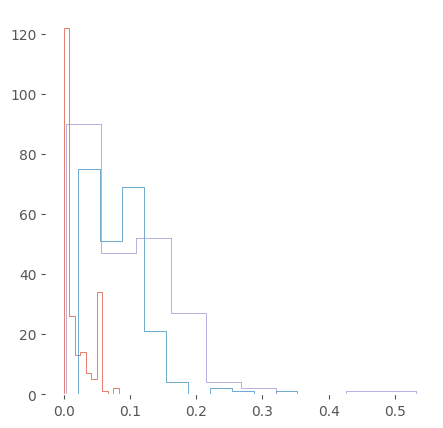

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.hist(df_shp_gtap['S1_ext_total'], histtype = 'step')
plt.hist(df_shp_gtap['S2_ext_total'], histtype = 'step')
plt.hist(df_shp_gtap['S3_ext_total'], histtype = 'step')

In [ ]:
print(min(df_shp_gtap['S1_ext_total']),max(df_shp_gtap['S1_ext_total']))
print(min(df_shp_gtap['S2_ext_total']),max(df_shp_gtap['S2_ext_total']))
print(min(df_shp_gtap['S3_ext_total']),max(df_shp_gtap['S3_ext_total']))

0.0 0.08337974001698334
0.021883889849801556 0.35297268658617936
0.003247812660569684 0.532025369334946


In [ ]:
colors1 = plt.cm.GnBu.reversed()(np.linspace(0, 1, 32))
colors2 = plt.cm.YlOrRd(np.linspace(0, 1, 128))
combined_colors = np.vstack((colors1, colors2))
combined_cmap = LinearSegmentedColormap.from_list('combined_cmap', combined_colors)

In [ ]:
min(df_shp_gtap['diff_23']),max(df_shp_gtap['diff_23'])

(-0.30277947995454013, 0.4430244275925372)

(array([ 1.,  3., 18., 81., 75., 34.,  6.,  4.,  1.,  1.]),
 array([-0.30277948, -0.22819909, -0.1536187 , -0.07903831, -0.00445792,
         0.07012247,  0.14470286,  0.21928326,  0.29386365,  0.36844404,
         0.44302443]),
 <BarContainer object of 10 artists>)

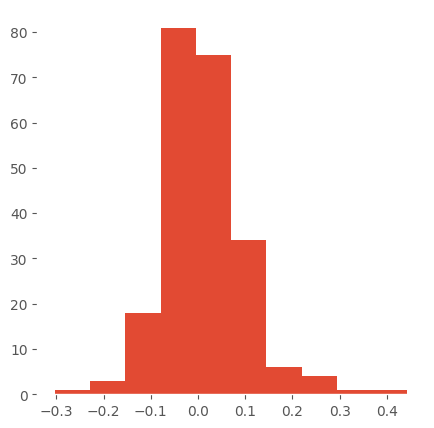

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.hist(df_shp_gtap['diff_23'])

In [ ]:
shifted_cmap_gtap = shiftedColorMap(matplotlib.cm.PiYG, midpoint=0.5/(0.5+0.5) ,name='shifted_gtap') # ,name='shifted_gtap'

(np.float64(0.13653052322347414), np.float64(0.5098076923076923), np.float64(0.36443895355305167), np.float64(0.3701923076923077))
(np.float64(0.5240305232234741), np.float64(0.5098076923076923), np.float64(0.36443895355305167), np.float64(0.3701923076923077))
(np.float64(0.13653052322347414), np.float64(0.10999999999999999), np.float64(0.36443895355305167), np.float64(0.3701923076923077))


<ipython-input-92-969e306ecdc0>:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar1.ax.set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '>0.5'])


(np.float64(0.5240305232234741), np.float64(0.10999999999999999), np.float64(0.36443895355305167), np.float64(0.3701923076923077))


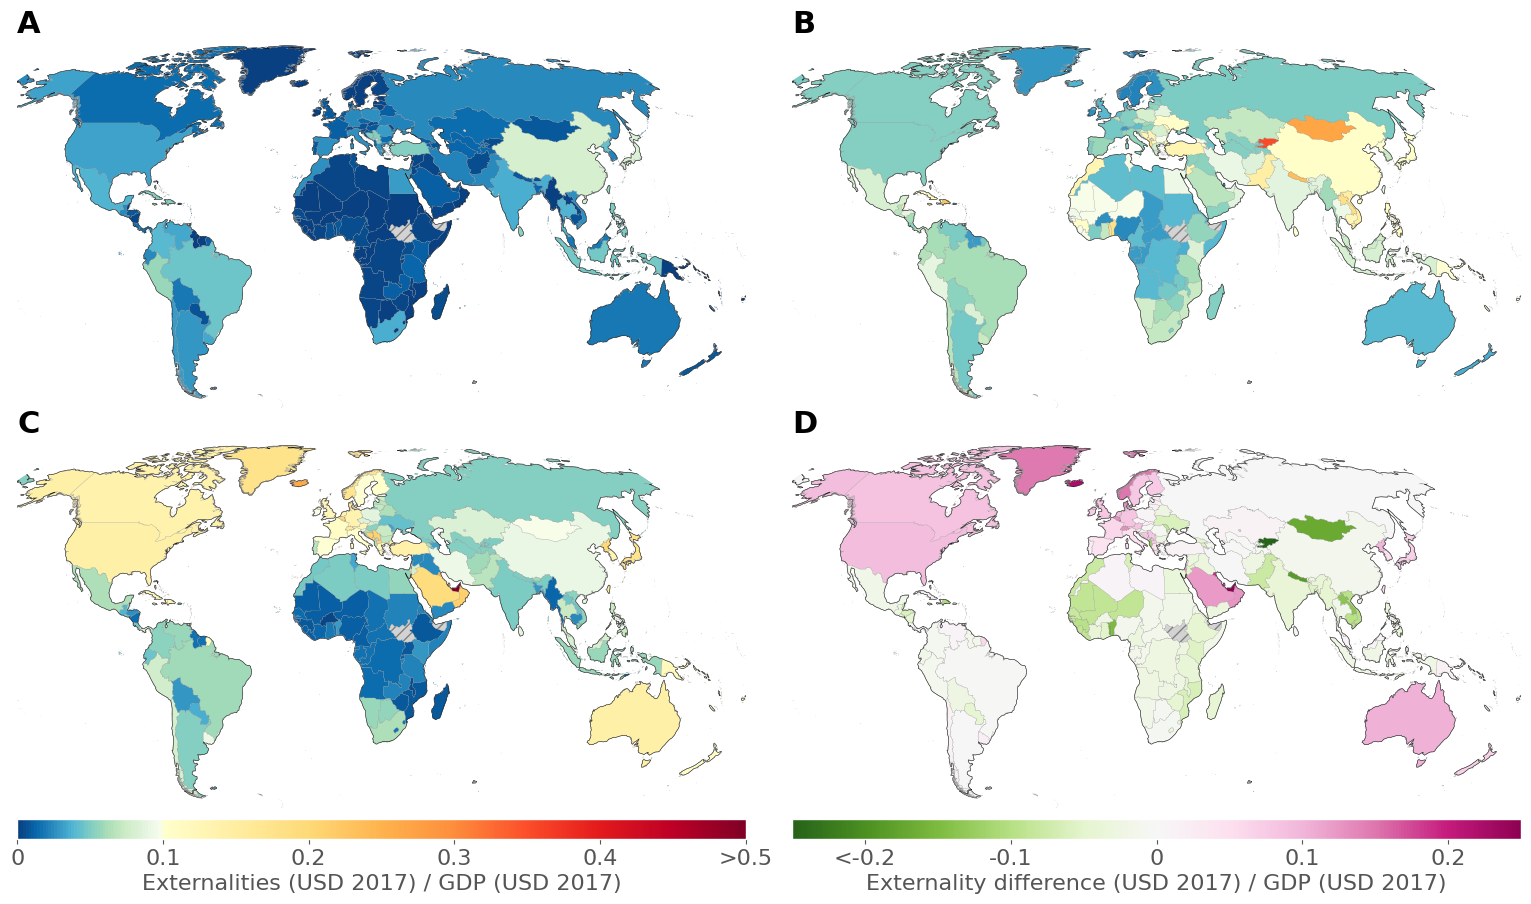

In [ ]:
# plot_columns_gtap = ['S1_ext_total_log','S2_ext_total_log','S3_ext_total_log','diff_12_log']
plot_columns_gtap = ['S1_ext_total','S2_ext_total','S3_ext_total','diff_23']

# Create a figure and a set of subplots
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 2, wspace=0,hspace=0.08)
# gs.update(hspace=0.001, wspace=0.001)

map_extent = [-135, 180, -60, 90]  # [lonmin, lonmax, latmin, latmax]

# Create subplots with Robinson projection
for i in range(4):
    ax = plt.subplot(gs[i], projection=ccrs.Robinson())
    ax.set_title(f"{string.ascii_uppercase[i]}", loc='left', pad=-0.5, fontsize=22,fontweight='bold')

    # Plot the data
    if i <= 2:
      df_shp_gtap.to_crs(ccrs.Robinson()).plot(
          linewidths=0, column=plot_columns_gtap[i], ax=ax, vmin=0, vmax=0.5, legend=False,
          cmap=combined_cmap, missing_kwds={
              "color": "lightgrey",
              "edgecolor": "grey",
              "hatch": "///",
              "label": "Missing values",
          }
      )
      df_shp_gtap.to_crs(ccrs.Robinson()).boundary.plot(ax=ax, linewidth=0.1, edgecolor='grey')
      ax.set_extent(map_extent, crs=ccrs.PlateCarree())



    if i == 3:
      df_shp_gtap.to_crs(ccrs.Robinson()).plot(
          linewidths=0, column=plot_columns_gtap[i], ax=ax, vmin=-0.25, vmax=0.25, legend=False,
          cmap=shifted_cmap_gtap.reversed(),missing_kwds={
              "color": "lightgrey",
              "edgecolor": "grey",
              "hatch": "///",
              "label": "Missing values",
          }
      )
      df_shp_gtap.to_crs(ccrs.Robinson()).boundary.plot(ax=ax, linewidth=0.1, edgecolor='grey')
      ax.set_extent(map_extent, crs=ccrs.PlateCarree())



    print(ax.get_position().bounds)
    # Customize colorbar: Horizontal
    if i == 2:
        l2, b2, w2, h2 = ax.get_position().bounds # position of the second plot, and I want the first color bar right below the third plot
        c_w = w2 # colorbar width
        c_h = 0.02 # colorbar height
        c_b = b2 - 0.03  # colorbar bottom
        c_l = l2 # colorbar left
        cbar_ax1 = fig.add_axes([c_l,c_b,c_w,c_h])
        cbar1 = fig.colorbar(ax.collections[0], cax=cbar_ax1, shrink=0.5, orientation='horizontal')
        # cbar1.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        cbar1.ax.tick_params(labelsize=16)
        cbar1.set_label('Externalities (USD 2017) / GDP (USD 2017)', fontsize=16)
        # Set custom tick labels for colorbar
        cbar1.ax.set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '>0.5'])
        # cbar1.ax.set_xticklabels(['10$^{7}$', '10$^{8}$', '10$^{9}$', '10$^{10}$', '10$^{11}$', '10$^{12}$']) # multiply everything by 1e6 and change the legend to just "USD YYYY"



    elif i == 3:
        l3, b3, w3, h3 = ax.get_position().bounds # position of the last plot, and I want the second color bar right below the last plot

        c_w = w3 # colorbar width
        c_h = 0.02 # colorbar height
        c_b = b3 - 0.03  # colorbar bottom
        c_l = l3 # colorbar left
        cbar_ax1 = fig.add_axes([c_l,c_b,c_w,c_h])
        cbar1 = fig.colorbar(ax.collections[0], cax=cbar_ax1, shrink=0.5, orientation='horizontal')
        cbar1.set_ticks([-0.2, -0.1, 0, 0.1, 0.2])
        cbar1.ax.tick_params(labelsize=16)
        cbar1.set_label('Externality difference (USD 2017) / GDP (USD 2017)', fontsize=16)
        # Set custom tick labels for colorbar
        cbar1.ax.set_xticklabels(['<-0.2','-0.1','0','0.1','0.2'])
        # cbar1.ax.set_xticklabels(['-10$^{10}$','-10$^{8}$','0','10$^{8}$','10$^{10}$','10$^{12}$']) # multiply everything by 1e6 and change the legend to just "USD YYYY"


    # Add coastlines and gridlines
    ax.coastlines(linewidths=0.4)
    # gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      # linewidth=2, color='gray', alpha=0.5, linestyle='--')
    # gl.xlabel_style = {'size': 12, 'color': 'gray'}
    # gl.ylabel_style = {'size': 12, 'color': 'gray'}

    plt.rcParams['axes.facecolor'] = 'white'

    ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
# Save the figure as a PDF
plt.savefig("First_review_plot/Fig4_GTAP.pdf", format='pdf', dpi=300, bbox_inches='tight')
# plt.tight_layout()
plt.show()
